# Predicting Turnout in 2020 General Election for Alamance County, NC

In [ ]:
# written by @caramnix 12.28.24 
# goal: predict turnout at individual level in Alamance County, NC for 2020 General election 

In [2]:
# imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import os
import statsmodels.api as sm
from sklearn import metrics

In [3]:
os.chdir("/Users/caranix/Documents/GitHub/AlamanceTurnout")

## Read in 2016 vf data for training

In [4]:
df= pd.read_csv("alamance_2016_vf_data.csv")

In [5]:
# I did mess around with including age or age group, age group performed better! 
variables_to_one_hot_encode= ['race_code','ethnic_code', 'party_cd', 'sex_code', 'age_group']

In [6]:
df_encoded = pd.get_dummies(df, columns=variables_to_one_hot_encode, drop_first=True)

In [7]:
# create variable which is if voted in election in past year (2015 for 2016, 2019 for 2020)
# note: this variable is misleading -- as not everyone in 2015 had an election to vote in 

df_encoded['2015_g']= df_encoded['2015_g'].astype(bool)
df_encoded['2015_o']= df_encoded['2015_o'].astype(bool)
df_encoded['voted_year_b4_eday'] = (df_encoded['2015_g'] | df_encoded['2015_o'])

In [8]:
df_encoded= df_encoded.rename(columns={'2016_p' :'voted_in_cycle_primary', 
                                       '2016_pr': 'voted_in_cycle_primary_runoff', 
                                       'voted_early_prior_to_2016_g': 'voted_early_prior_to_in_cycle_general'})

In [9]:

# use vote history from 2015 and 2016 
# i.e. voted in any election in the year before election day? 1/0 
# i.e. voted in primary in-cycle 


####  features to include: #####
# voted_year_b4_eday : Did person vote in year before election day 
# voted_in_cycle_primary : Did person vote in the primary in-cycle 
# voted_in_cycle_primary_runoff : Did person vote in the primary in-cycle runoff election 
# voted_early_prior_to_in_cycle_general : Did person vote early prior to the in cycle general election? 
# race : reference category is Asian 
# age group : reference category is Age 18-26 
# political party: reference is Dem 
# sex: reference is Female 
# in_cycle_reg : did person register in this cycle/ year, i.e. for 2020 general did they register in 2020 
# turnout_pct: historical turnout oct for their precinct! 


feature_cols = ['voted_year_b4_eday', 'voted_in_cycle_primary', 'voted_early_prior_to_in_cycle_general', 'voted_in_cycle_primary_runoff',
       'race_code_B', 'race_code_I', 'race_code_M', 'race_code_O', 'age_group_Age 26 - 40', 'age_group_Age 41 - 65','age_group_Age Over 66',
       'race_code_U', 'race_code_W', 'ethnic_code_NL', 'ethnic_code_UN',
       'party_cd_LIB', 'party_cd_REP', 'party_cd_UNA', 'sex_code_M',
       'sex_code_U', 'in_cycle_reg', 'turnout_pct'] 
X_train = df_encoded[feature_cols] # Features
y_train = df_encoded['2016_g'] # Target variable (voted or not in 2016 general!)

In [10]:
# for those who didn't vote prior to general, we have no data on if they would have voted early or not, 
# so fill NA's with 0's because they did not vote early (and did have opportunity too...most likely)
X_train['voted_early_prior_to_in_cycle_general'].fillna(0, inplace=True)

# Additionally, we fill NA's for voted in cycle primary with 0, because any registrerd voter could have voted in primary! (note: could filter based on registeration date to ensure we aren't assigning people who weren't registered yet 0's)
X_train['voted_in_cycle_primary'].fillna(0, inplace=True)

#Okay! now, for primary runoff it's a little trickier-- because not every person had opportunity to vote in a runoff (since both parties didn't have them, thus, fill in with .5, because we can't say they should eb negatively punished )
X_train['voted_in_cycle_primary_runoff'].fillna(.5, inplace=True)

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/3719978495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['voted_early_prior_to_in_cycle_general'].fillna(0, inplace=True)
/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/3719978495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['voted_in_cycle_primary'].fillna(0, inplace=True)
/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/3719978495.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

In [11]:
# check to make sure after filling NA's that they there are no NA's-- log regression won't work w/ NA's 
X_train.isna().sum()

voted_year_b4_eday                       0
voted_in_cycle_primary                   0
voted_early_prior_to_in_cycle_general    0
voted_in_cycle_primary_runoff            0
race_code_B                              0
race_code_I                              0
race_code_M                              0
race_code_O                              0
age_group_Age 26 - 40                    0
age_group_Age 41 - 65                    0
age_group_Age Over 66                    0
race_code_U                              0
race_code_W                              0
ethnic_code_NL                           0
ethnic_code_UN                           0
party_cd_LIB                             0
party_cd_REP                             0
party_cd_UNA                             0
sex_code_M                               0
sex_code_U                               0
in_cycle_reg                             0
turnout_pct                              3
dtype: int64

In [12]:
# fill in w/ mean if no turnout pct exists 
X_train.fillna(X_train['turnout_pct'].mean(), inplace=True)

# Na's in outcome variable mean they were registered voters but have no voting history, so that means they didn't vote 
print(y_train.isna().sum()) 

y_train.fillna(0, inplace=True)

print(y_train.isna().sum()) 

20148
0


/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/2283423663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(X_train['turnout_pct'].mean(), inplace=True)


In [13]:
# some type conversion! 
y_train= y_train.astype(int)
X_train[['voted_year_b4_eday', 'race_code_B', 'race_code_I',
       'race_code_M', 'race_code_O', 'race_code_U', 'race_code_W',
       'ethnic_code_NL', 'ethnic_code_UN', 'party_cd_LIB', 'party_cd_REP',
       'party_cd_UNA', 'sex_code_M', 'sex_code_U', 'age_group_Age 26 - 40', 'age_group_Age 41 - 65', 'age_group_Age Over 66', 
         'in_cycle_reg',
       ]]= X_train[['voted_year_b4_eday', 'race_code_B', 'race_code_I',
       'race_code_M', 'race_code_O', 'race_code_U', 'race_code_W',
       'ethnic_code_NL', 'ethnic_code_UN', 'party_cd_LIB', 'party_cd_REP',
       'party_cd_UNA', 'sex_code_M', 'sex_code_U', 'in_cycle_reg', 'age_group_Age 26 - 40', 'age_group_Age 41 - 65','age_group_Age Over 66'
       ]].astype(int)

# our model!! wooO!! 
model= sm.Logit(np.asarray(y_train), sm.add_constant(np.asarray(X_train))).fit()



/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/2895456401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['voted_year_b4_eday', 'race_code_B', 'race_code_I',


Optimization terminated successfully.
         Current function value: 0.250545
         Iterations 8


In [14]:
# get column names
col_names= list(X_train.columns)
col_names.insert(0, "coeff")

# let's look at summary output 
model.summary(xname= col_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                86670
Model:                          Logit   Df Residuals:                    86647
Method:                           MLE   Df Model:                           22
Date:                Sat, 28 Dec 2024   Pseudo R-squ.:                  0.5841
Time:                        11:42:48   Log-Likelihood:                -21715.
converged:                       True   LL-Null:                       -52218.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
coeff                                    -0.9022      0.284     -3.175      0.001      -1.459      -0.345
voted_year_b4_eday                       -3.3814      0.038    -88.280      0.000      -3.457      -3.306
voted_in_cycle_primary                    3.6563      0.052     70.436      0.000       3.555       3.758
voted_early_prior_to_in_cycle_general     0.9591      0.076     12.574      0.000       0.810       1.109
voted_in_cycle_primary_runoff            -2.2117      0.063    -35.214      0.000      -2.335      -2.089
race_code_B                              -0.0454      0.152     -0.298      0.766      -0.344       0.253
race_code_I                              -0.1088      0.295     -0.369      0.712      -0.686       0.469
race_code_M                              -0.1957      0.204     -0.958      0.338      -0.596       0.205
race_code_O                              -0.4623      0.178     -2.603      0.009      -0.810      -0.114
age_group_Age 26 - 40                     0.3828      0.037     10.381      0.000       0.311       0.455
age_group_Age 41 - 65                     0.5305      0.043     12.320      0.000       0.446       0.615
age_group_Age Over 66                     1.0851      0.041     26.415      0.000       1.005       1.166
race_code_U                              -0.1250      0.168     -0.745      0.456      -0.454       0.204
race_code_W                              -0.1258      0.150     -0.837      0.403      -0.420       0.169
ethnic_code_NL                           -0.2126      0.090     -2.365      0.018      -0.389      -0.036
ethnic_code_UN                           -0.3827      0.091     -4.213      0.000      -0.561      -0.205
party_cd_LIB                             -0.2009      0.178     -1.128      0.259      -0.550       0.148
party_cd_REP                              0.0608      0.036      1.712      0.087      -0.009       0.130
party_cd_UNA                             -0.2631      0.034     -7.650      0.000      -0.331      -0.196
sex_code_M                               -0.0211      0.026     -0.807      0.419      -0.072       0.030
sex_code_U                               -0.0177      0.099     -0.179      0.858      -0.212       0.176
in_cycle_reg                              1.4779      0.049     30.256      0.000       1.382       1.574
turnout_pct                               3.1719      0.304     10.427      0.000       2.576       3.768
=========================================================================================================
"""

In [15]:
# only print coefficennts with significant pvalues, i..e have an impact on turnout 
# these are the features which have significant coefficents 
# also included direction, so if negative this means a decrease in odds of turnout! 

# exponentiate values so can interpret via odds 
coeff_vals= np.exp(model.params)

# let's pull p values too 
p_vals= model.pvalues

# (https://stats.stackexchange.com/questions/412668/how-to-interpret-a-negative-coefficient-in-logistic-regression) 
for i in range(len(col_names)): 
    if p_vals[i] <=.005:
        if model.params[i] >= 0 : 
            print(col_names[i] + " : " + str(coeff_vals[i]))
        if model.params[i] < 0 : 
            print(col_names[i] + " : -" + str(coeff_vals[i]))
            
# interp: voting in-cycle primary leads to an increase in odds of general election turnout by 32.8
# interp: voting year before election day leads to decrease in odds in turnout [this is against expectations, possibly due to lack of midterm data]
# interp: registering incycle increase odds of turnout by 4 
# interp: a one-unit increase in turnout percentage within your precinct leads to odds increase of 21 of turnout!
# interp: voting early prior to in cycle general leads to increase of 2.6 


coeff : -0.40568580842285856
voted_year_b4_eday : -0.033998713038654316
voted_in_cycle_primary : 38.71664710501061
voted_early_prior_to_in_cycle_general : 2.6092423488156293
voted_in_cycle_primary_runoff : -0.1095149539156015
age_group_Age 26 - 40 : 1.4664531748771101
age_group_Age 41 - 65 : 1.699757286893867
age_group_Age Over 66 : 2.9597772351624876
ethnic_code_UN : -0.6819988500690537
party_cd_UNA : -0.7686316314054725
in_cycle_reg : 4.383741019317127
turnout_pct : 23.853253510069383


In [16]:
# so for logistic regression we can also predict on our "training" data to see how well we did -- one way to eval model 
predicted_probabilities = model.predict(sm.add_constant(X_train[list(X_train.columns)]))

In [17]:
y_pred= predicted_probabilities > .5
y_pred= y_pred.astype(int)

In [18]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87     25167
           1       0.92      0.98      0.95     61503

    accuracy                           0.93     86670
   macro avg       0.93      0.89      0.91     86670
weighted avg       0.93      0.93      0.93     86670



In [19]:
def table(predicted_probs, labels, cutoff):
    """ Replacement for R's table funcion. """
    predicted_outcome = (predicted_probs > cutoff).astype(int)
    df = pd.DataFrame({"predicted_outcome": predicted_outcome, "actual_outcome": labels})
    return pd.crosstab(index=df["actual_outcome"], columns=df["predicted_outcome"], margins=False)

In [20]:
table(predicted_probabilities, y_train, cutoff=0.5)

predicted_outcome,0,1
actual_outcome,,
0,20228,4939
1,1263,60240


In [21]:
# new test on 2020, read in 2020 data! 

df2= pd.read_csv("alamance_2020_vf_data.csv")


In [22]:
df2_encoded = pd.get_dummies(df2, columns=variables_to_one_hot_encode, drop_first=True)

# create variable which is if voted in election in past year (2015 for 2016, 2019 for 2020)
df2_encoded['2019_g']= df2_encoded['2019_g'].astype(bool)
df2_encoded['2019_o']= df2_encoded['2019_o'].astype(bool)

df2_encoded['voted_year_b4_eday'] = (df2_encoded['2019_g'] | df2_encoded['2019_o'])


In [23]:
df2_encoded= df2_encoded.rename(columns={'2020_p' :'voted_in_cycle_primary', 
                                       '2020_pr': 'voted_in_cycle_primary_runoff', 
                                       'voted_early_prior_to_2020_g': 'voted_early_prior_to_in_cycle_general'})


In [24]:
feature_cols = ['voted_year_b4_eday', 'voted_in_cycle_primary', 'voted_early_prior_to_in_cycle_general', 'voted_in_cycle_primary_runoff',
       'race_code_B', 'race_code_I', 'race_code_M', 'race_code_O',
       'race_code_U', 'race_code_W', 'ethnic_code_NL', 'ethnic_code_UN',
       'party_cd_LIB', 'party_cd_REP', 'party_cd_UNA', 'sex_code_M',
       'sex_code_U', 'age_group_Age 26 - 40', 'age_group_Age 41 - 65',
       'age_group_Age Over 66', 'in_cycle_reg', 'turnout_pct'] 
X_test = df2_encoded[feature_cols] # Features
y_test = df2_encoded['2020_g'] # Target variable

In [25]:
X_test['voted_early_prior_to_in_cycle_general'].fillna(0, inplace=True)
X_test['voted_in_cycle_primary'].fillna(0, inplace=True)
X_test['voted_in_cycle_primary_runoff'].fillna(.5, inplace=True)


/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/2670848330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['voted_early_prior_to_in_cycle_general'].fillna(0, inplace=True)
/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/2670848330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['voted_in_cycle_primary'].fillna(0, inplace=True)
/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/2670848330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [26]:
y_test.fillna(0, inplace=True)

In [27]:
X_test.fillna(X_test['turnout_pct'].mean(), inplace=True)

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/1022703458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(X_test['turnout_pct'].mean(), inplace=True)


In [28]:
cols= ['voted_year_b4_eday', 'race_code_B', 'race_code_I',
       'race_code_M', 'race_code_O', 'race_code_U', 'race_code_W',
       'ethnic_code_NL', 'ethnic_code_UN', 'party_cd_LIB', 'party_cd_REP',
       'party_cd_UNA', 'sex_code_M', 'sex_code_U', 'age_group_Age 26 - 40', 'age_group_Age 41 - 65',
       'age_group_Age Over 66', 'in_cycle_reg']

X_test[cols]= X_test[cols].astype(int)

/var/folders/09/l3m63nj90fg1l2jshjp_hd5w0000gn/T/ipykernel_52796/1443878231.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[cols]= X_test[cols].astype(int)


In [29]:
predicted_probabilities_2020= model.predict(sm.add_constant(X_test[list(X_test.columns)]))

In [30]:
y_pred= predicted_probabilities_2020 > .5
y_pred= y_pred.astype(int)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     23653
         1.0       0.92      0.99      0.95     78569

    accuracy                           0.93    102222
   macro avg       0.94      0.85      0.88    102222
weighted avg       0.93      0.93      0.92    102222



In [32]:
table(predicted_probabilities_2020, y_test, cutoff=0.5)

predicted_outcome,0,1
actual_outcome,,
0.0,16707,6946
1.0,614,77955


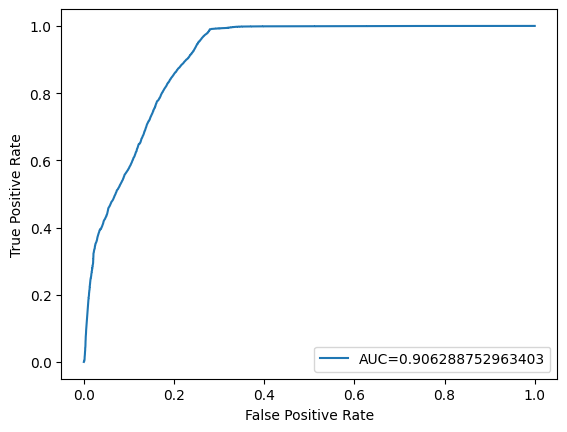

In [33]:
# let's look at ROC too
fpr, tpr, _ = metrics.roc_curve(y_test,  predicted_probabilities_2020)
auc = metrics.roc_auc_score(y_test,  predicted_probabilities_2020)

#create ROC curve
plt.plot(fpr,tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#https://www.statology.org/plot-roc-curve-python/